In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
from collections import defaultdict
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgspy.theory import bgs_segment, bgs_segment_sc16

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

In [4]:
@np.vectorize
def ok71(rho):
    return (10 + rho) / (22 + 13*rho + rho**2)

@np.vectorize
def neutral_ld(L, rbp, N, s=None, u=None):
    # N is *diploid* pop size
    R = rbp * L
    fun = lambda x: ok71(4*N*rbp*x) * (2-2*x) * R
    return integrate.quad(fun, 0, 1)[0]

In [5]:
## params for all sims, fixed across everything
rbp = 1e-8
L = 100_000 # total region length
N = 1000

In [6]:
d = pd.read_pickle('../data/slim_sims/region/region_results.pkl')
d.head()

,generation,k_mean,k_sd,k3,k4,f_mean,f_sd,f3,f4,s,...,B,ratchet,sh,N,rbp,mu,U,r2sum,ldsum,ldn
0,9991,0.044,0.210019,0.044098,0.049723,0.995610,0.020911,-4.302140e-05,4.696870e-06,0,...,0.679993,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.1000,1000,1.000000e-08,3.160000e-08,0.003160,1.000292,0.000209,24
1,9991,0.030,0.182025,0.038994,0.053141,0.999054,0.005730,-1.207780e-06,5.111660e-08,0,...,0.968271,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.0316,1000,1.000000e-08,1.000000e-08,0.001000,0.000116,-0.000114,6
2,9991,0.000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0,...,2.167800,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.0001,1000,1.000000e-08,3.160000e-10,0.000032,0.000000,0.000000,0
3,9991,3.422,2.554300,3.717170,90.757300,0.999658,0.000255,-3.708790e-12,9.064470e-15,1,...,1.963898,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.0001,1000,1.000000e-08,3.160000e-09,0.000316,5.109915,1.073531,10
4,9991,0.005,0.070569,0.004925,0.004901,0.999842,0.002230,-1.554140e-07,4.886640e-09,0,...,1.053806,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.0316,1000,1.000000e-08,3.160000e-09,0.000316,0.000013,-0.000013,3


In [7]:
dg = d.groupby(['sh', 'rbp', 'N', 'mu', 'U']).mean().reset_index()

In [8]:
dg['sh'].unique()

array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
       0.1     ])

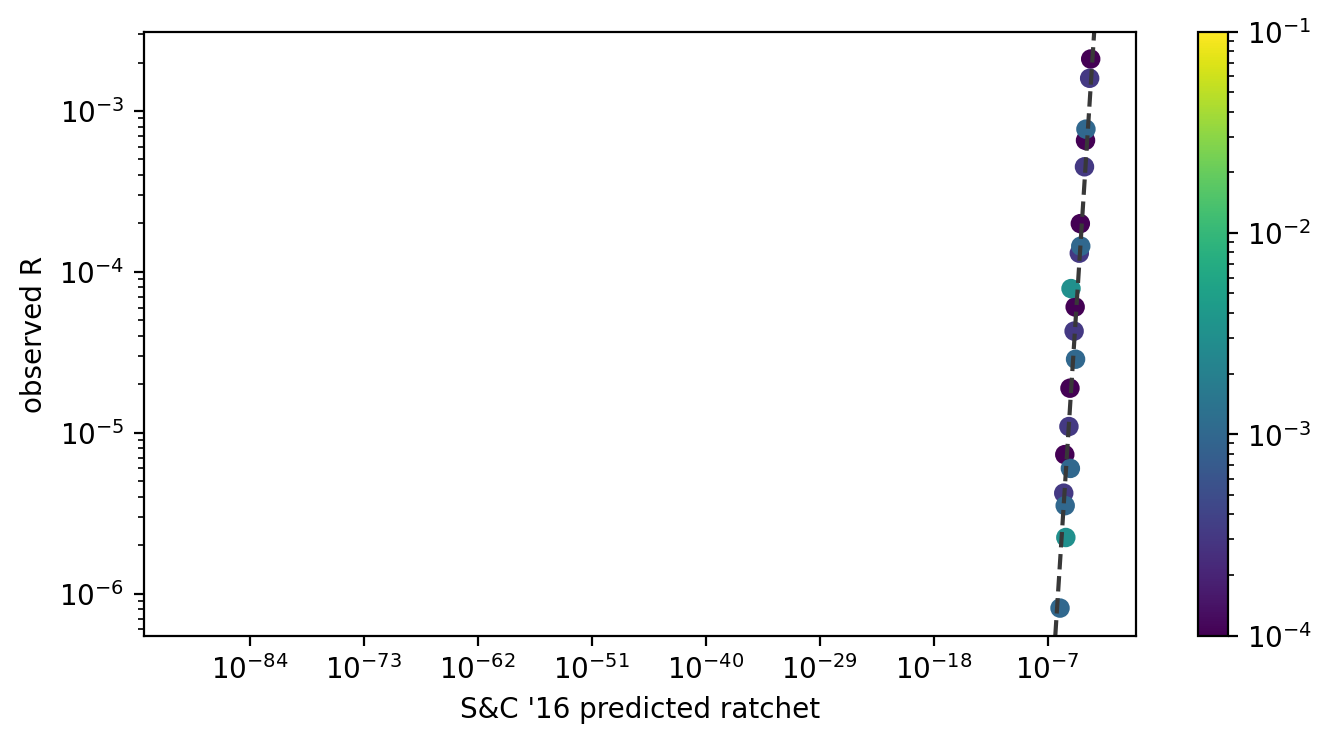

In [9]:
mu, sh = dg.mu, dg.sh
T, Ne, *_ = bgs_segment_sc16(mu, sh, L, rbp, N, return_both=True)

#plt.scatter(0.5/T, dg['R'], c=np.log10(dg['sh'])) #NOTE factor of two

lognorm = mpl.colors.LogNorm()

plt.scatter(0.5/T, dg['R'], c=dg['sh'], norm=lognorm) #NOTE factor of two
plt.axline((0, 0), slope=1, c='0.22', linestyle='dashed')
plt.loglog()
plt.xlabel("S&C '16 predicted ratchet")
plt.ylabel("observed R")
plt.colorbar()

#plt.xlim((1e-7, 1e-3))

In [10]:
dg['mu'].unique()

array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08])

Text(0, 0.5, 'Var(k)')

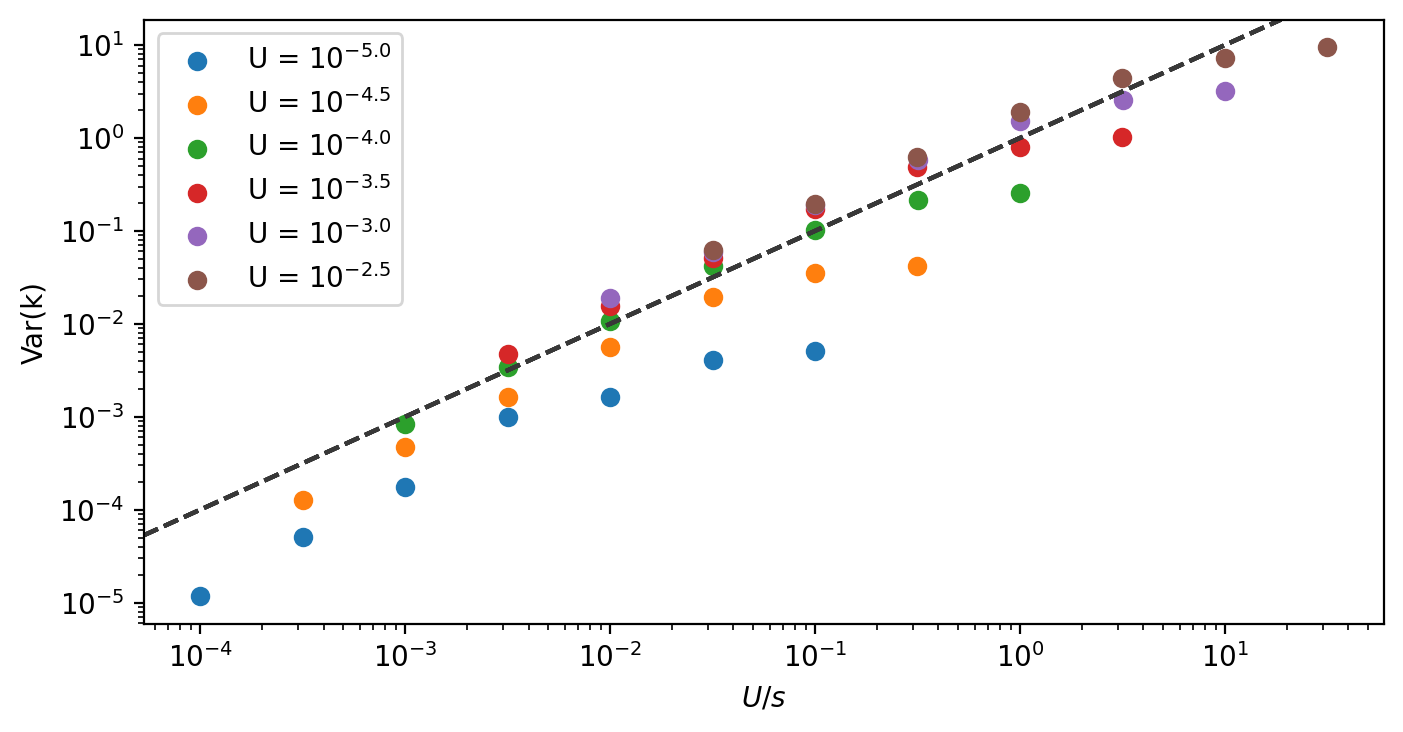

In [11]:


for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]
    sh = np.logspace(-5, -1, 100)
    plt.scatter(dgs['U']/dgs['sh'], dgs['k_sd']**2, label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
    rate = dgs['U']/dgs['sh']
    plt.axline((0, 0), slope=1, c='0.22', linestyle='dashed')

plt.loglog()
plt.legend()
plt.xlabel("$U/s$")
plt.ylabel("Var(k)")

In [12]:
from scipy.optimize import fsolve, broyden1, broyden2, root
import warnings

@np.vectorize
def bgs_segment_sc16p(mu, sh, L, rbp, N, full_output=False, return_both=False):
    U = L*mu
    Vm = U*sh**2
    start_T = (np.exp(2*sh*N) - 1)/(2*U*sh*N)
    def func(x):
        T, Ne = x
        V = U*sh - sh/T
        VmV = Vm/V
        #Q2 = 1/(VmV * (VmV + L*rbp/2))
        Q2 = 2*V**2 / (Vm*(L*rbp*(V-Vm) + 2*Vm))
        if T <= 0:
            T = 1000*N
        #print(2*sh*Ne, Ne, T)
        return [np.log(((np.expm1(2*sh*Ne))/(2*U*sh*Ne)) / T),
                 np.log(N * np.exp(-V*Q2) / Ne)]
    out = fsolve(func, [start_T, N], full_output=True)
    #return out.x[1]
    Ne = out[0][1]
    T =  out[0][0]
    V = U*sh - sh/T
    VmV = Vm/V
    #Q2 = 1/(VmV * (VmV + L*rbp/2))
    Q2 = 2*V**2 / (Vm*(L*rbp*(V-Vm) + 2*Vm))
    if full_output:
        return out
    if out[2] != 1:
        warnings.warn("no solution found!")
        return np.nan
    if return_both:
        return float(T), float(Ne), float(Q2), float(V), float(Vm), float(U)
    return float(Ne)

bgs_segment_sc16p(3.16e-8, 1e-2, L, rbp, N, full_output=True)

(array([5.72393590e+07, 7.40010543e+02]),
 array({'nfev': 73, 'fjac': array([[-1.00000000e+00,  1.46996383e-05],
        [-1.46996383e-05, -1.00000000e+00]]), 'r': array([ 1.75272205e-08, -1.60379508e-02,  1.33528825e-03]), 'qtf': array([ 2.92109306e-09, -1.65544511e-11]), 'fvec': array([ 2.35564901e-11, -1.42552636e-13])},
       dtype=object),
 array(1),
 array('The solution converged.', dtype='<U23'))

In [13]:
dg['theory_V'] = dg['U'] * dg['sh'] -  dg['sh'] *  dg['R']

In [14]:
sc16_V = bgs_segment_sc16p(dg['mu'].values, dg['sh'].values, L, rbp, N, return_both=True)[3]

/tmp/ipykernel_78406/1276765101.py:31: UserWarning: no solution found!
  warnings.warn("no solution found!")


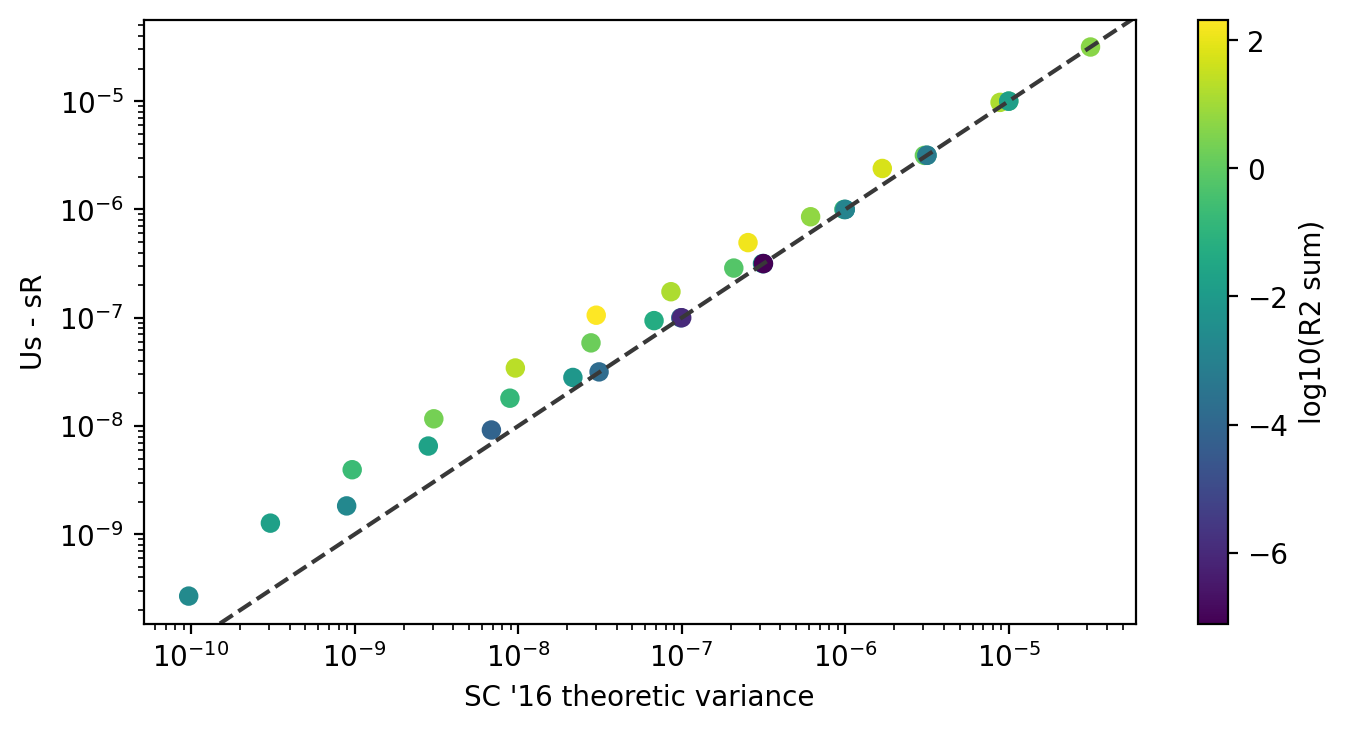

In [15]:
plt.scatter(sc16_V, dg['theory_V'], c=np.log10(dg['r2sum']))
plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.xlabel("SC '16 theoretic variance")
plt.ylabel('Us - sR') 
plt.colorbar(label="log10(R2 sum)")


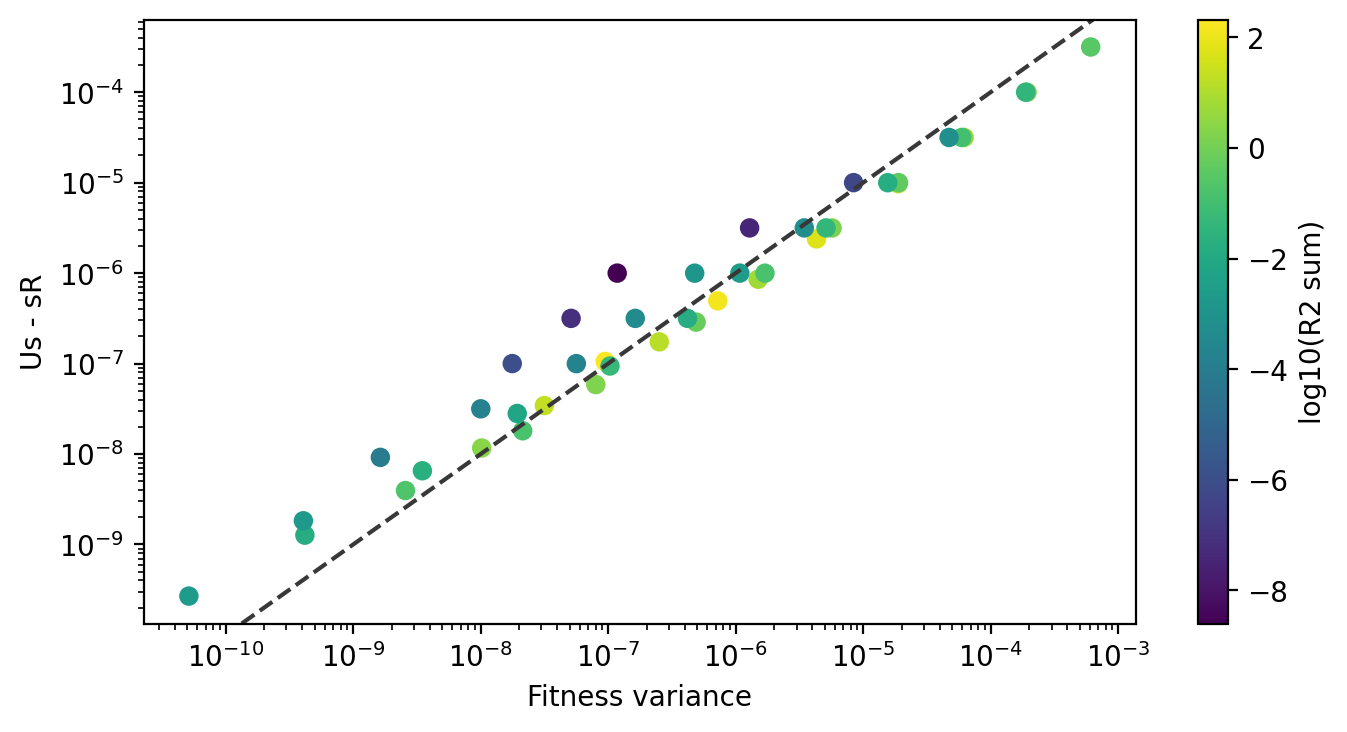

In [16]:
plt.scatter(dg['f_sd']**2, dg['theory_V'], c=np.log10(dg['r2sum']))
plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.xlabel("Fitness variance")
plt.ylabel('Us - sR')
plt.colorbar(label="log10(R2 sum)")


[]

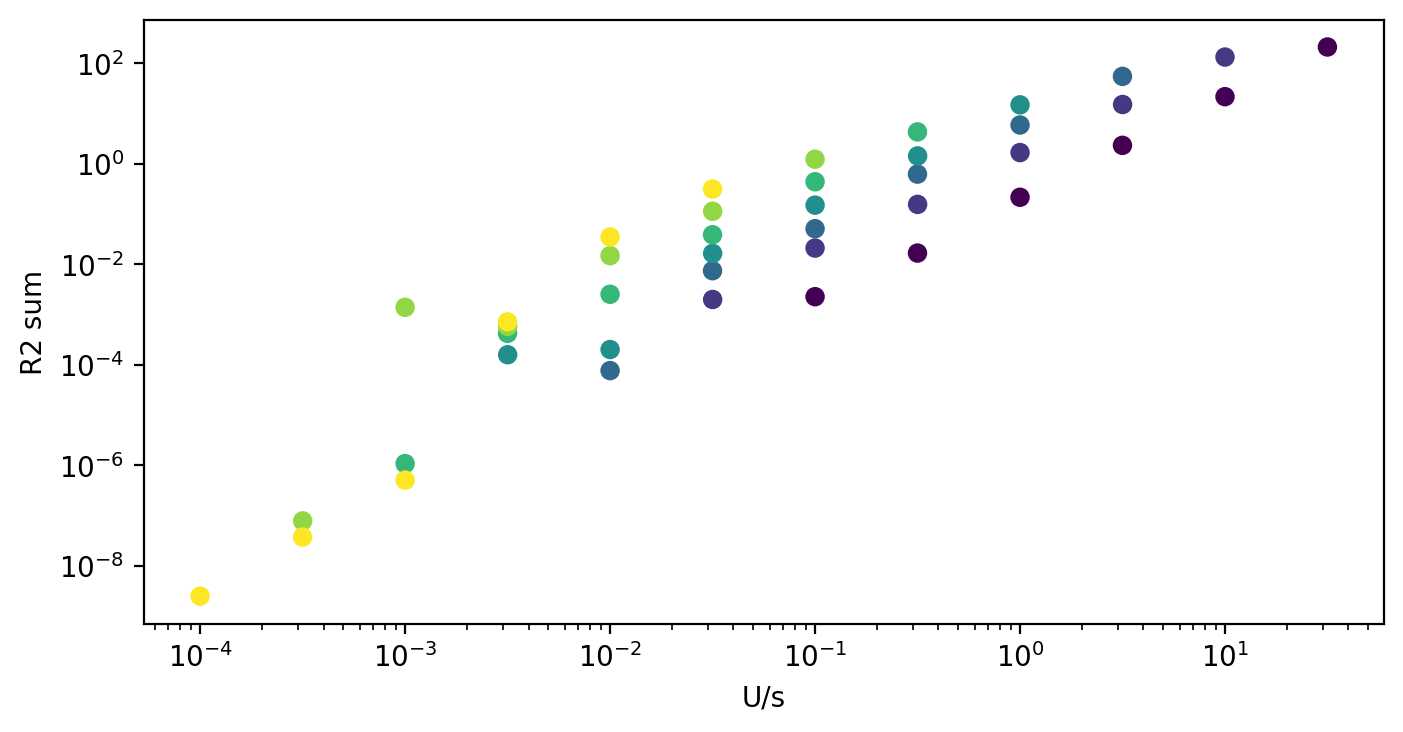

In [17]:
plt.scatter(dg['U']/dg['sh'], np.abs(dg['r2sum']), c=np.log10(dg['sh']))
plt.xlabel("U/s")
plt.ylabel("R2 sum")
plt.loglog()

[]

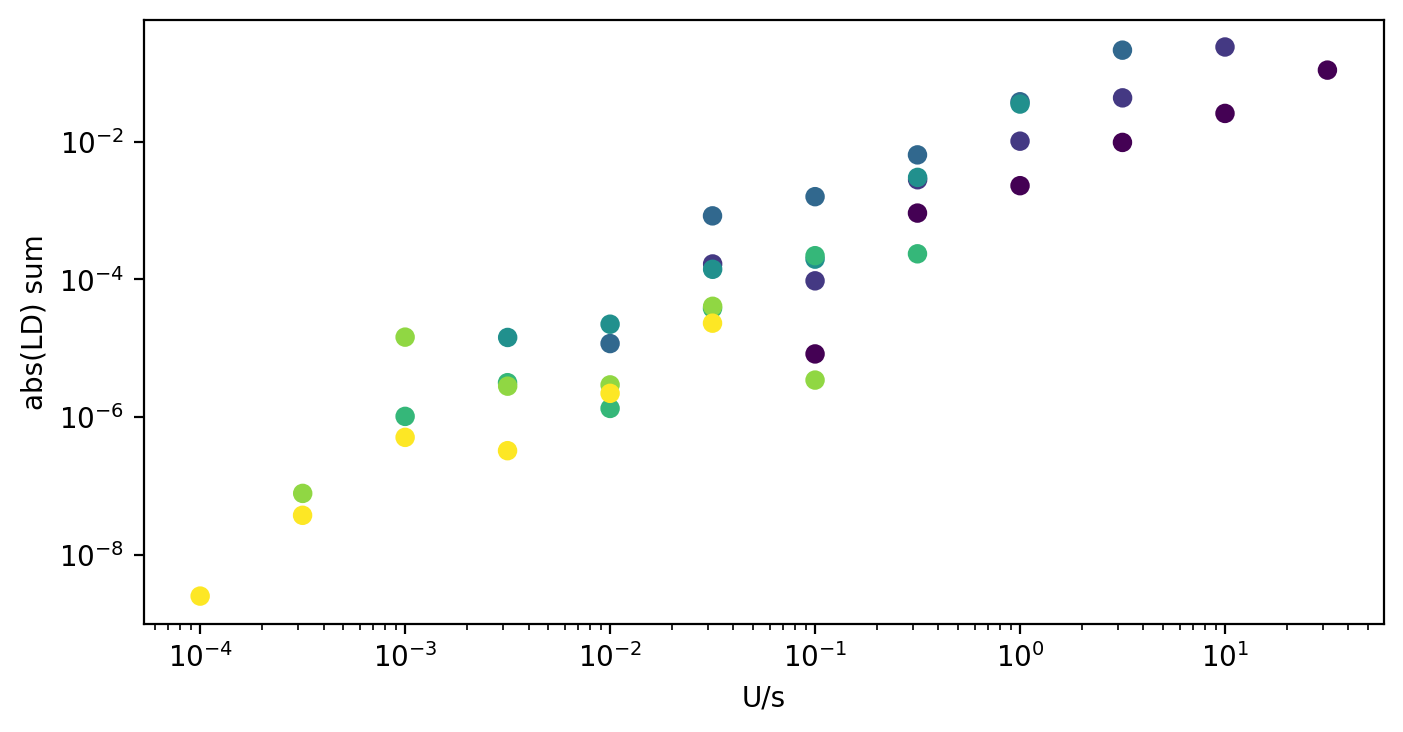

In [18]:
plt.scatter(dg['U']/dg['sh'], np.abs(dg['ldsum']), c=np.log10(dg['sh']))
plt.xlabel("U/s")
plt.ylabel("abs(LD) sum")
plt.loglog()

[]

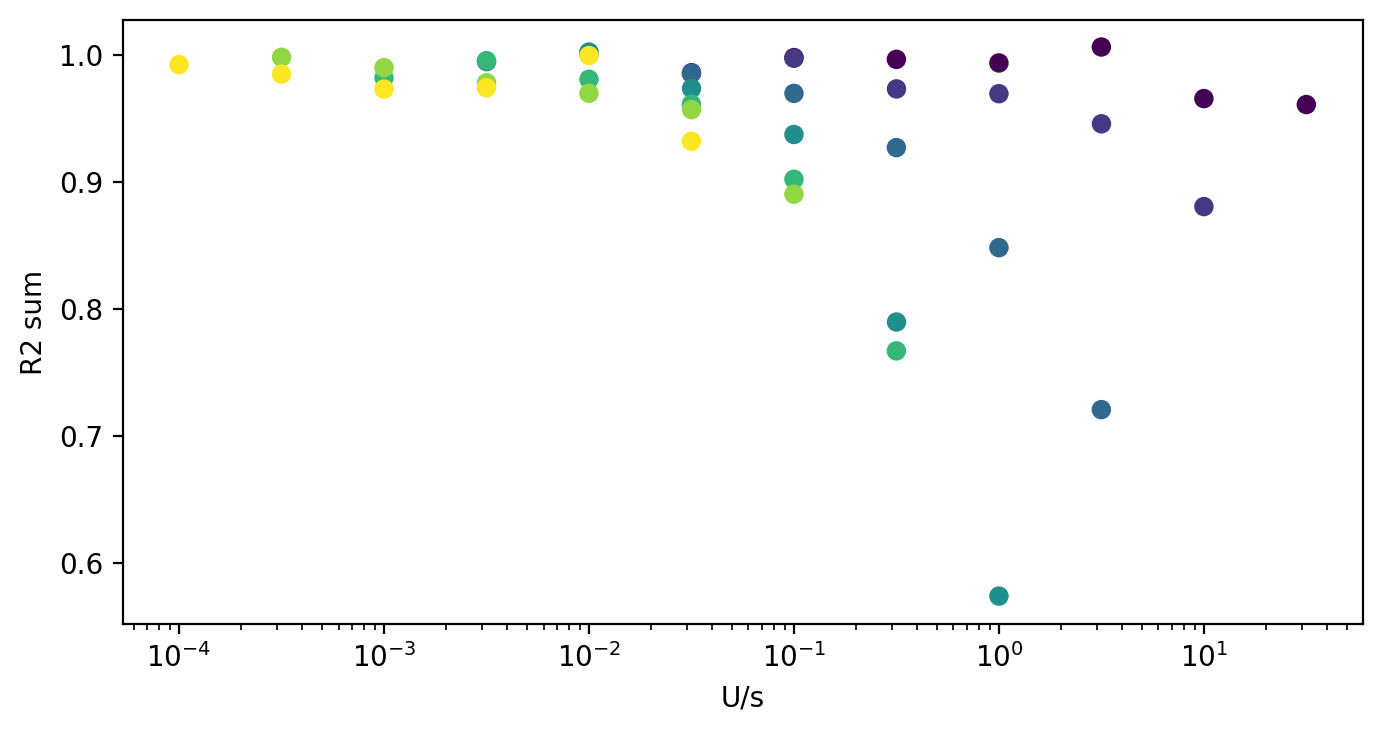

In [19]:
plt.scatter(dg['U']/dg['sh'], dg['B'], c=np.log10(dg['sh']))
plt.xlabel("U/s")
plt.ylabel("R2 sum")
plt.semilogx()

Text(0.5, 0, 'U/s')

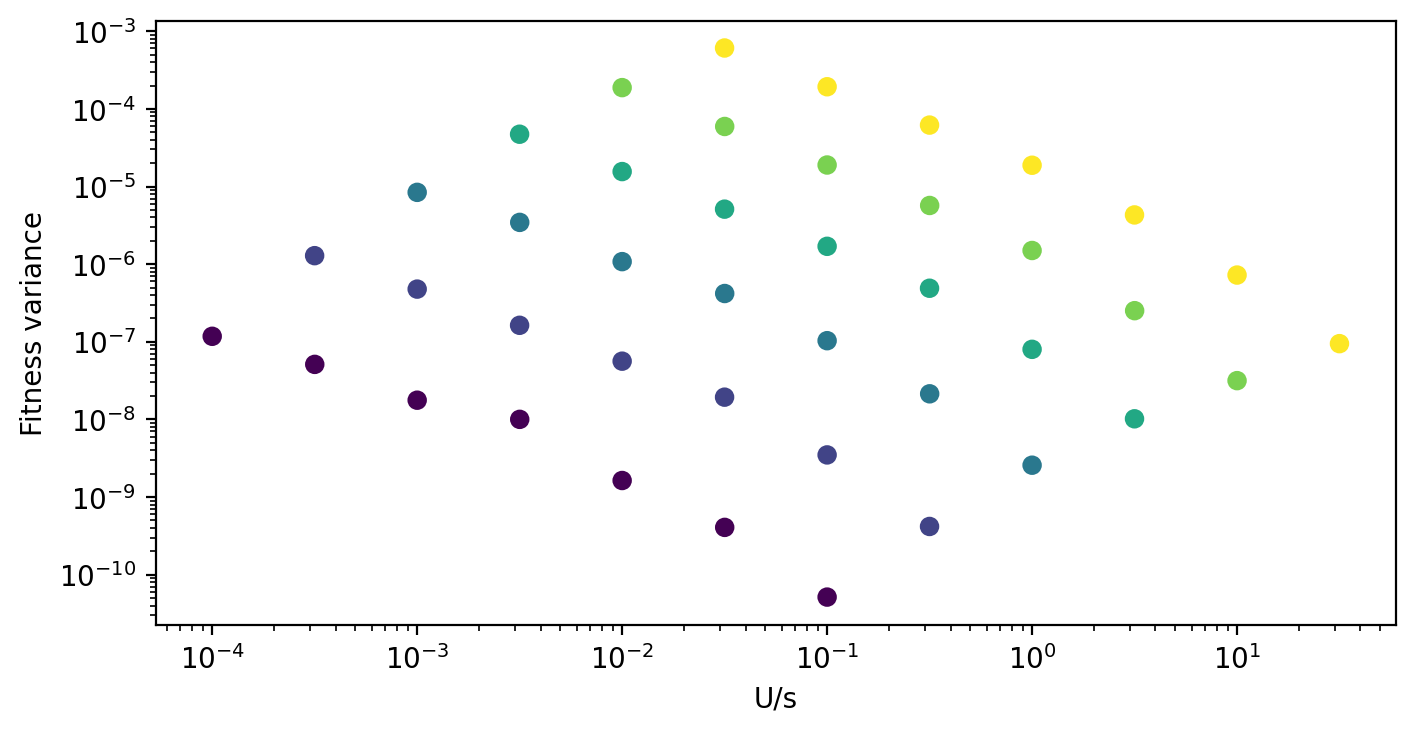

In [20]:
plt.scatter(L*dg['mu']/dg['sh'], dg['f_sd']**2, c=np.log10(dg['mu']))
plt.loglog()
plt.ylabel("Fitness variance")
plt.xlabel('U/s')

/tmp/ipykernel_78406/1276765101.py:31: UserWarning: no solution found!
  warnings.warn("no solution found!")
/tmp/ipykernel_78406/1276765101.py:31: UserWarning: no solution found!
  warnings.warn("no solution found!")
/tmp/ipykernel_78406/1276765101.py:31: UserWarning: no solution found!
  warnings.warn("no solution found!")
/tmp/ipykernel_78406/1276765101.py:31: UserWarning: no solution found!
  warnings.warn("no solution found!")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.4, 1.05)

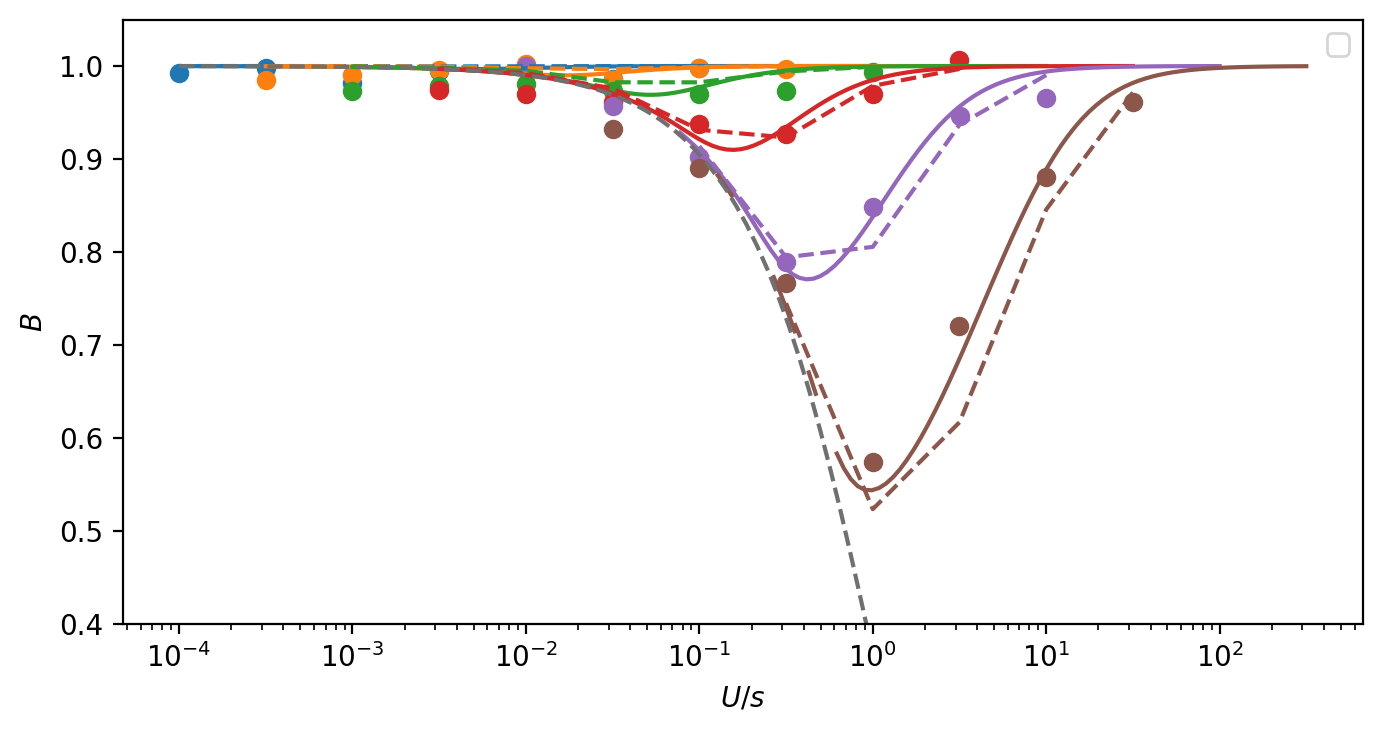

In [23]:
for mu in dg['mu'].unique():
    dgs = dg.loc[dg['mu'] == mu]
    sh = np.logspace(-5, -1, 100)
    #lines = plt.plot(mu/sh, bgs_segment_sc16p(mu, sh, L, rbp, N)/N, label=f"U = $10^{{{np.round(np.log10(mu), 2)}}}$")
    
    U = mu * L
    sh = dgs['sh'].values
    V = 2 * dgs['sh']**2 * dgs['ssh']
    #V = dgs['ssh'] * dgs['sh']**2 # dgs['f_sd']**2
    #V = dgs['f_sd']**2
    Vm = U*sh**2
    VmV = V/Vm
    Q2 = 1/(VmV * (VmV + L*rbp/2))
    res = bgs_segment_sc16p(mu, sh, L, rbp, N, return_both=True)
    V, Q2 = res[3], res[2]
    V = dgs['f_sd']**2 / 2 # FACTOR OF TWO
    lines = plt.plot(U/dgs['sh'], np.exp(-V * Q2), linestyle='dashed')
    
    plt.scatter(U/dgs['sh'], dgs['B'], c=lines[0].get_color()) 
    sh = np.logspace(-5, -1, 100)
    plt.plot(U/sh, bgs_segment_sc16p(mu, sh, L, rbp, N)/N, c=lines[0].get_color())
rate = np.logspace(-9, -3, 100)
plt.plot(L*rate, np.exp(-L * rate), linestyle='dashed', c='0.44')
    
plt.legend()
plt.semilogx()
plt.xlabel("$U/s$")
plt.ylabel("$B$")
plt.ylim(0.4, 1.05)

/tmp/ipykernel_46730/1276765101.py:31: UserWarning: no solution found!
  warnings.warn("no solution found!")
/tmp/ipykernel_46730/1276765101.py:31: UserWarning: no solution found!
  warnings.warn("no solution found!")


(0.4, 1.0)

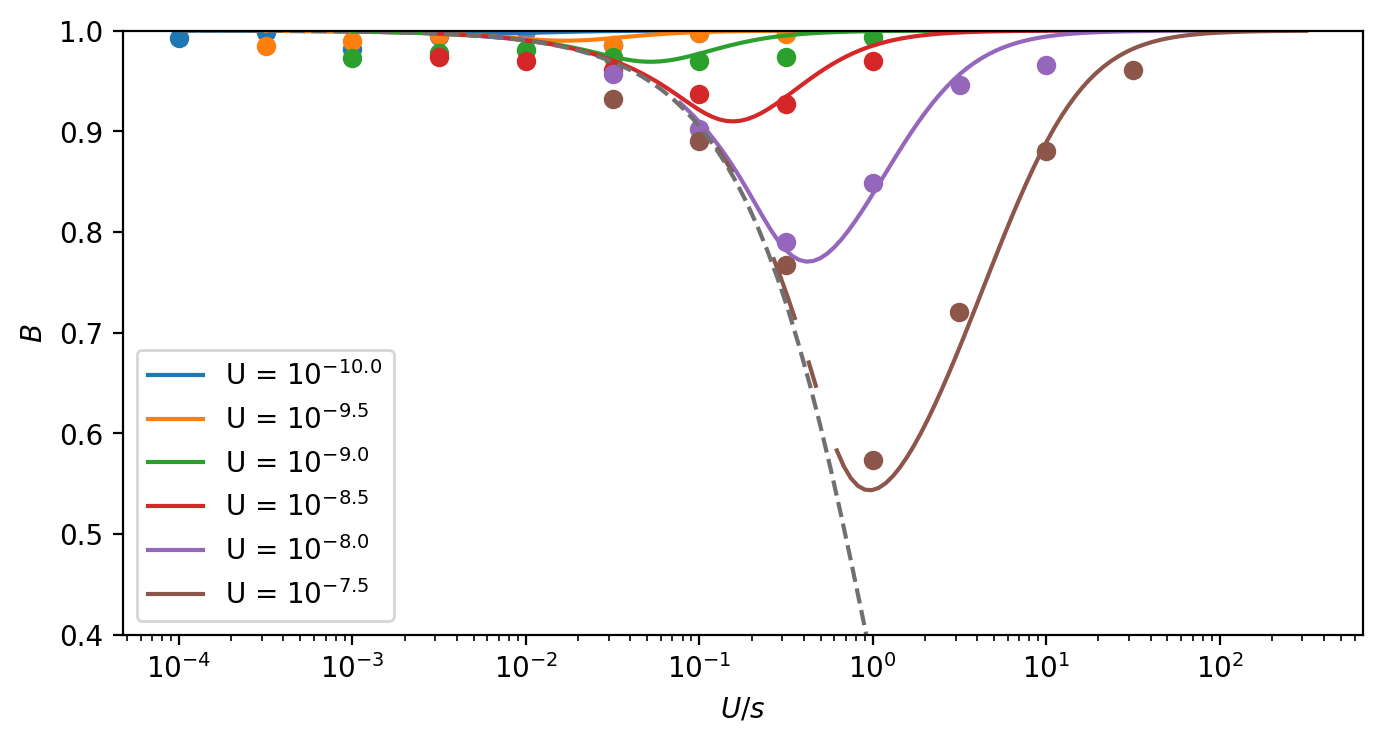

In [177]:
for mu in dg['mu'].unique():
    dgs = dg.loc[dg['mu'] == mu]
    sh = np.logspace(-5, -1, 100)
    lines = plt.plot(L*mu/sh, bgs_segment_sc16p(mu, sh, L, rbp, N)/N, label=f"U = $10^{{{np.round(np.log10(mu), 2)}}}$")
    
    U = mu * L
    sh = dgs['sh'].values
    V = 2 * dgs['sh']**2 * dgs['ssh']
    Vm = U*sh**2
    VmV = V/Vm
    Q2 = 1/(VmV * (VmV + L*rbp/2))
    #V = bgs_segment_sc16(mu, sh, L, rbp, N)[3]
    #lines = plt.plot(dgs['mu']/dgs['sh'], np.exp(-V * Q2), linestyle='dashed')
    
    plt.scatter(dgs['U']/dgs['sh'], dgs['B'], c=lines[0].get_color()) 
    
rate = np.logspace(-9, -3, 100)
plt.plot(L*rate, np.exp(-L * rate), linestyle='dashed', c='0.44')
    
plt.legend()
plt.semilogx()
plt.xlabel("$U/s$")
plt.ylabel("$B$")
plt.ylim(0.4, 1)

/home/vsb/projects/bprime/bgspy/theory.py:52: RuntimeWarning: invalid value encountered in log
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:64: UserWarning: no solution found!
  warnings.warn("no solution found!")


[]

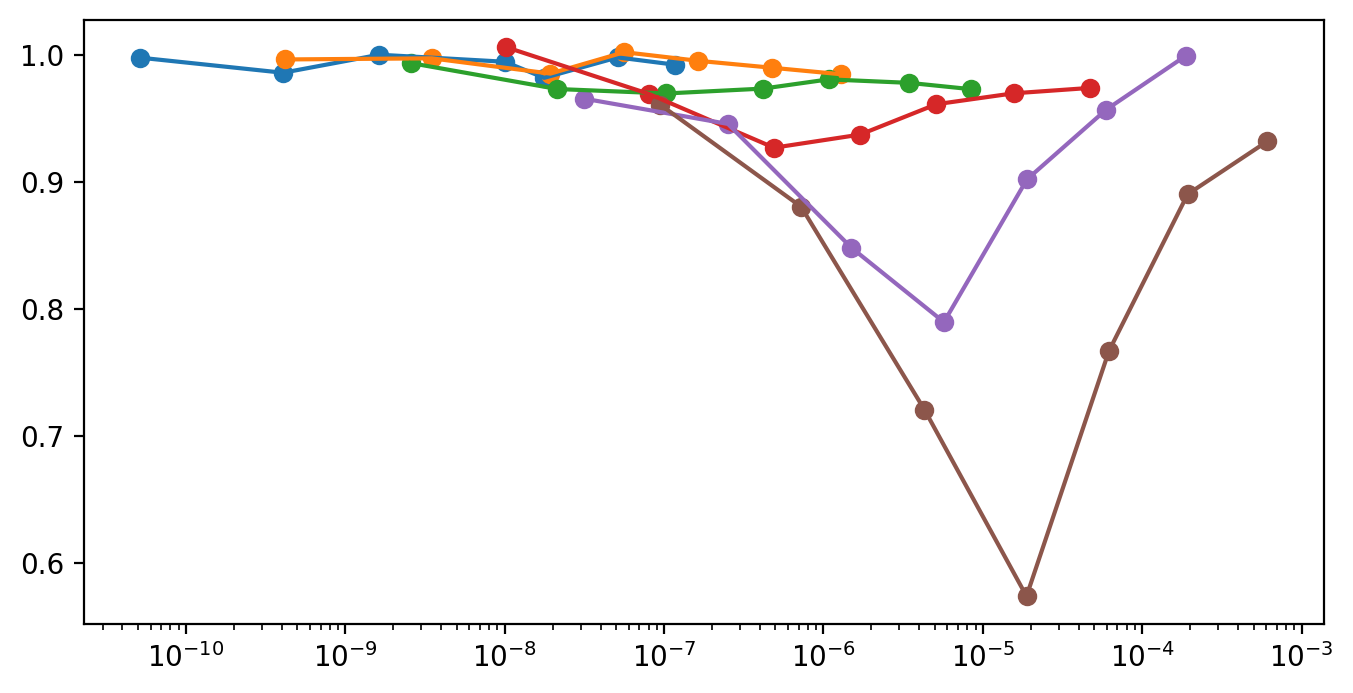

In [115]:
for u in dg['U'].unique():
    dgs = dg.loc[dg.U == u]
    lines = plt.plot(dgs['f_sd']**2, dgs['B'], label=u)
    plt.scatter(dgs['f_sd']**2, dgs['B'], c=lines[0].get_color())

T, Ne, _, V, *_ = bgs_segment_sc16(dg['mu'], dg['sh'], L, rbp, N, return_both=True)


#plt.scatter(dg['U'] / dg['sh'], V, c=np.log10(dg['sh']), marker='+')
plt.semilogx()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'predicted fitness variation')

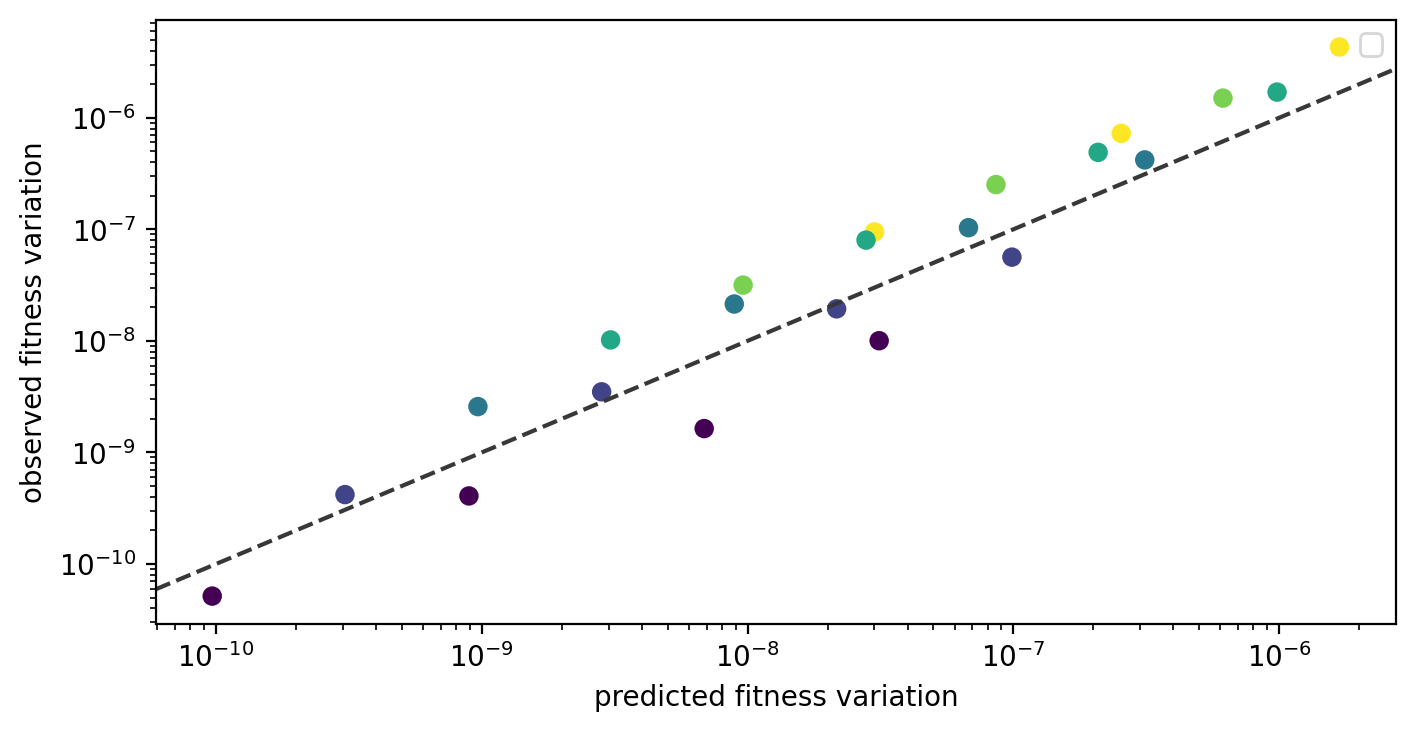

In [180]:
T, Ne, _, V, *_ = bgs_segment_sc16(dg['mu'], dg['sh'], L, rbp, N, return_both=True)
plt.scatter(V, dg['f_sd']**2, c=np.log10(dg['mu']))
plt.legend()
plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.ylabel('observed fitness variation')
plt.xlabel('predicted fitness variation')

Text(0.5, 0, 'predicted fitness variation')

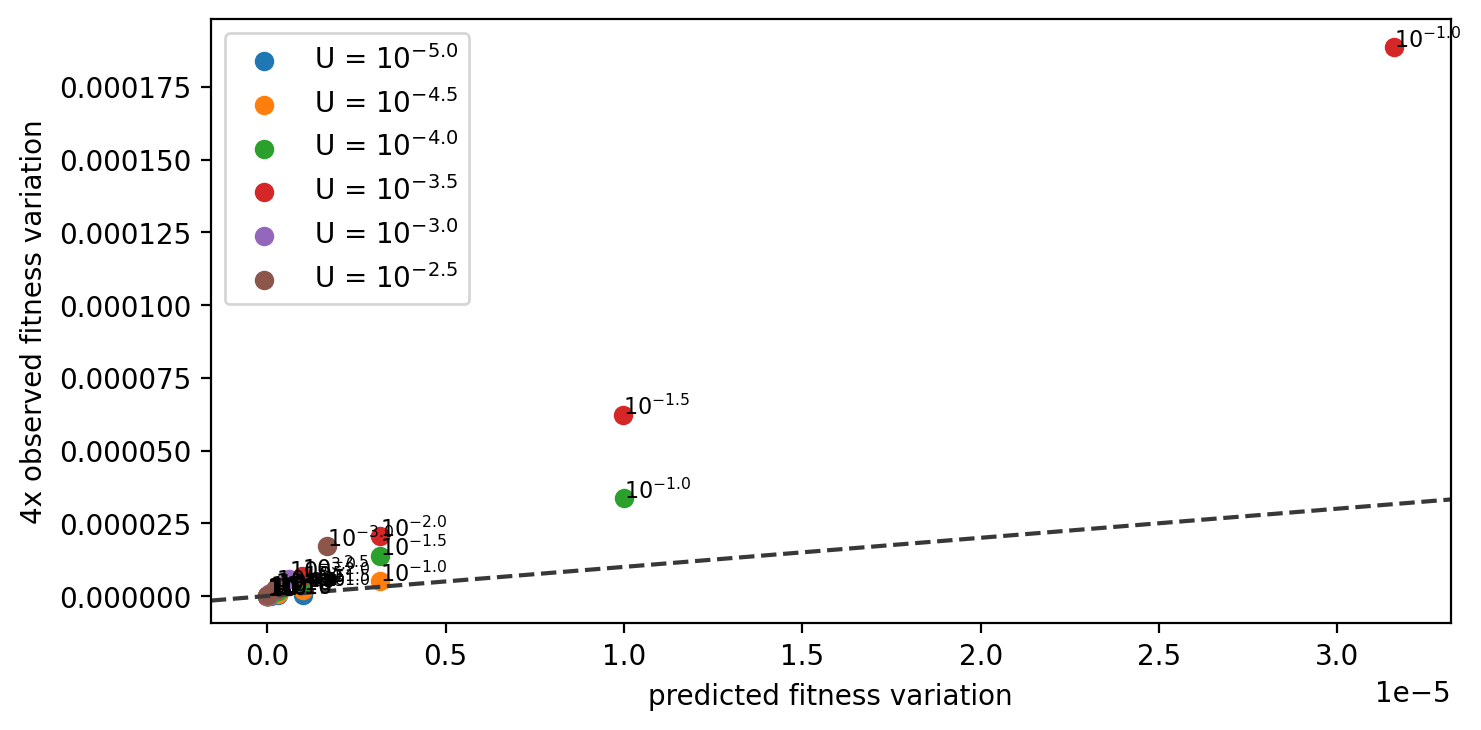

In [17]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vemp = 4 * dgs['f_sd'].values**2 
    
    plt.scatter(V, Vemp, label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
    
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (V[i], Vemp[i]), fontsize=8)
plt.legend()
plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
#plt.loglog()
plt.ylabel('4x observed fitness variation')
plt.xlabel('predicted fitness variation')

### Fitness Variation

Let's look at empirical fitness variation versus predicted under S&C '16:

Text(0.5, 0, 'predicted fitness variation')

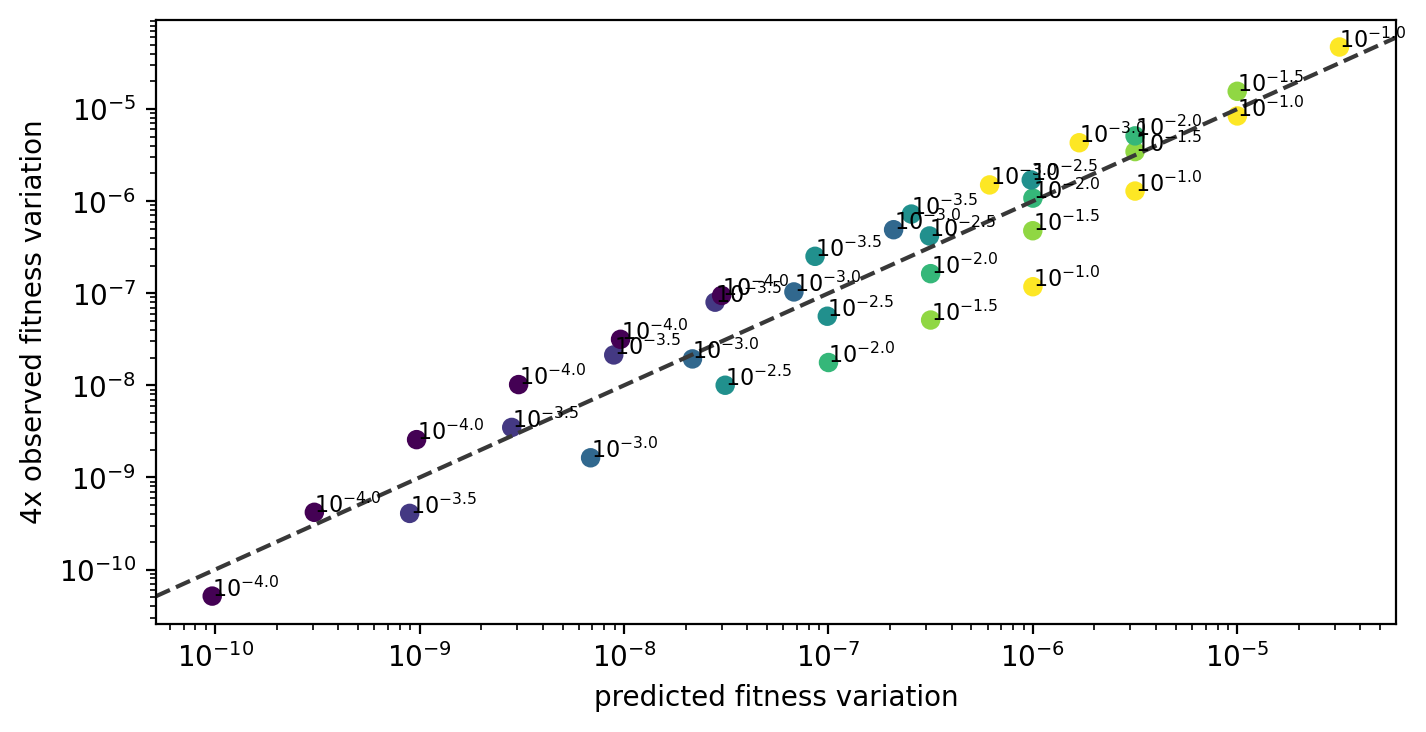

In [21]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vemp = dgs['f_sd'].values**2 
    #Vemp = dgs['sh'].values**2 * dgs['ssh'].values
    plt.scatter(V, Vemp, c = np.log10(dgs['sh']))
    
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (V[i], Vemp[i]), fontsize=8)

plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.ylabel('4x observed fitness variation')
plt.xlabel('predicted fitness variation')

Now, let's look at at the genic variance. This is incredibly close; the disparity must be LD.

Text(0.5, 0, 'predicted fitness variation')

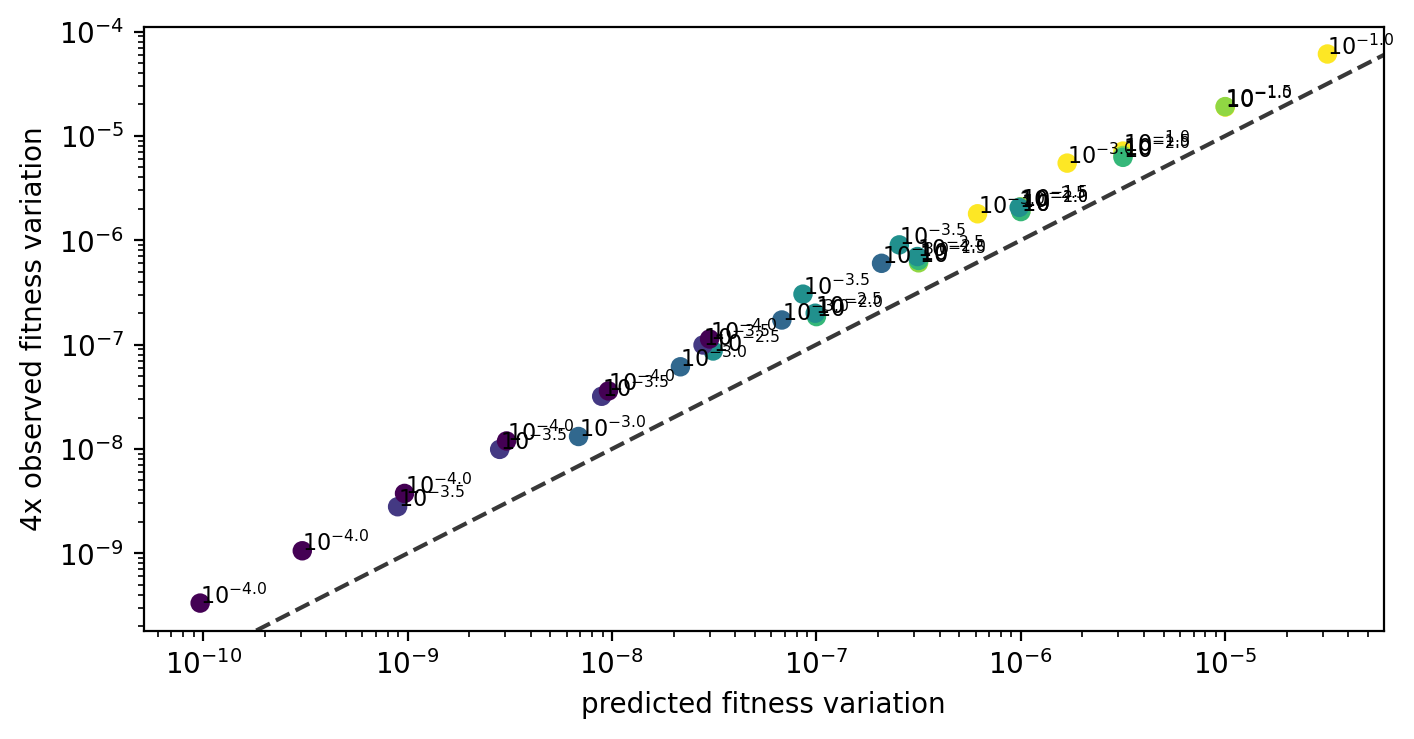

In [25]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    #Vemp = 4 * dgs['f_sd'].values**2 
    Vemp = dgs['sh'].values**2 * dgs['ssh'].values
    plt.scatter(V, Vemp, c = np.log10(dgs['sh']))
    
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (V[i], Vemp[i]), fontsize=8)

plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.ylabel('4x observed fitness variation')
plt.xlabel('predicted fitness variation')

Text(0.5, 0, 'predicted fitness variation')

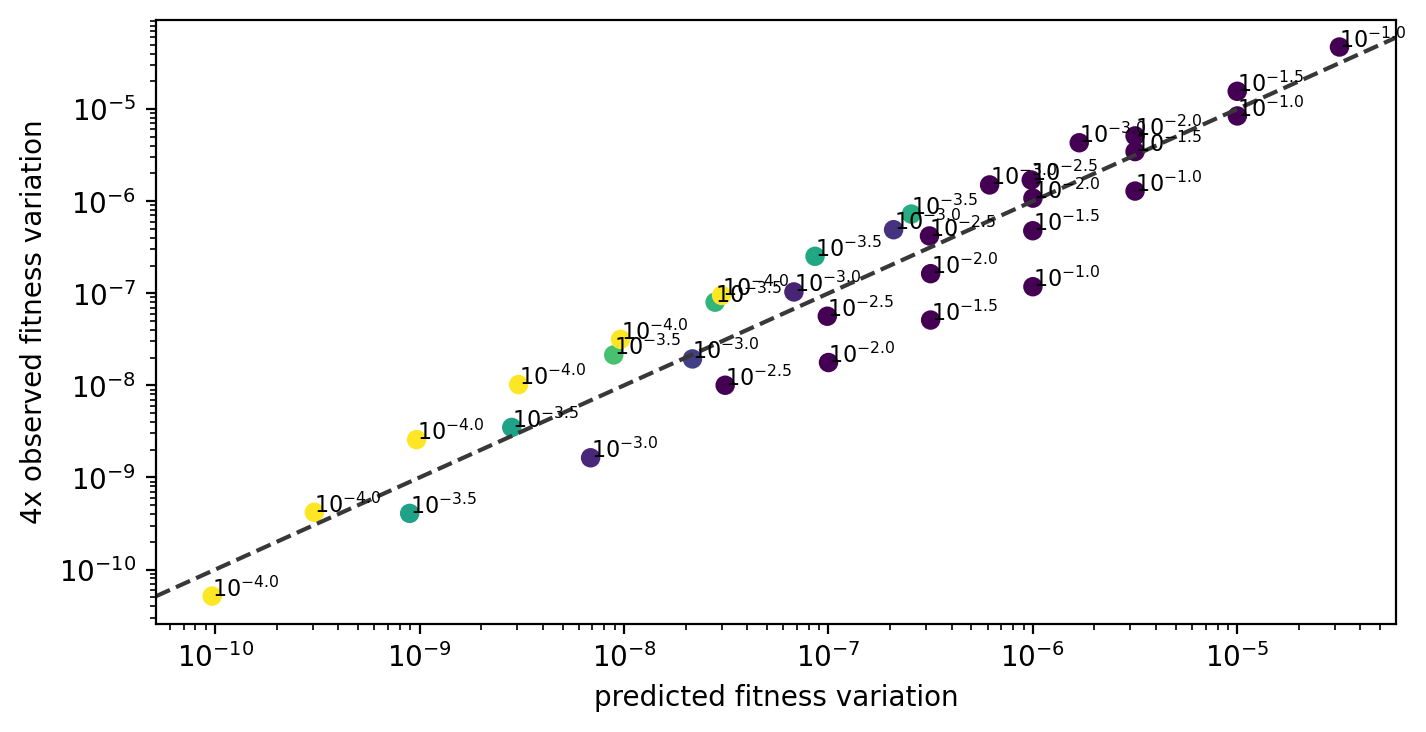

In [26]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vemp = dgs['f_sd'].values**2 
    #Vemp = 4 * dgs['sh'].values**2 * dgs['ssh'].values
    plt.scatter(V, Vemp, c = np.log10(0.1+dgs['R']))
    
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (V[i], Vemp[i]), fontsize=8)

plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.ylabel('4x observed fitness variation')
plt.xlabel('predicted fitness variation')

Text(0.5, 0, 'genic - Va')

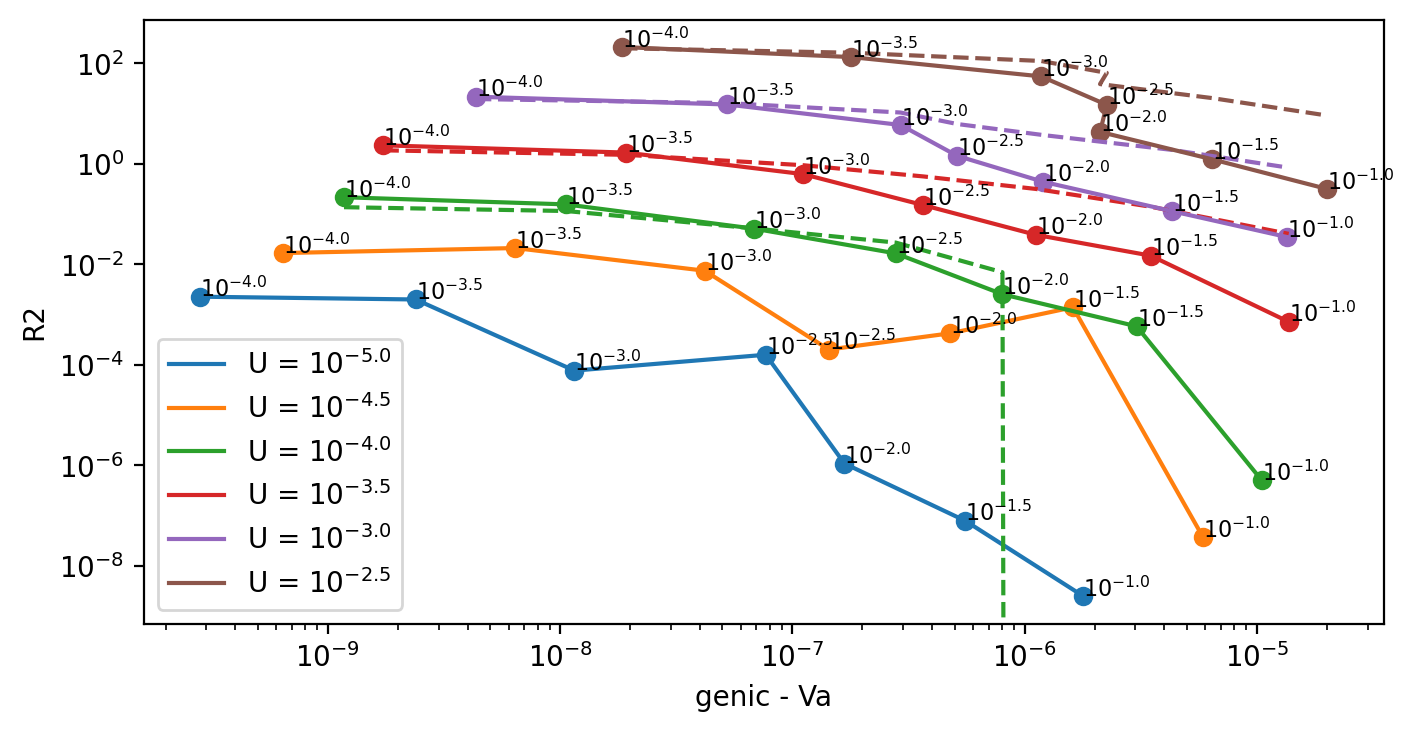

In [32]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    #T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vemp = dgs['f_sd'].values**2 
    Vemp_ssh =  dgs['sh'].values**2 * dgs['ssh'].values
    
    Vdiff = np.abs(Vemp - Vemp_ssh)
    
    lines = plt.plot(Vdiff, dgs['r2sum'], label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
    plt.scatter(Vdiff, dgs['r2sum'], c=lines[0].get_color())
    x = Vdiff 
    y = dgs['r2sum'].values
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (x[i], y[i]), fontsize=8)
    n = dgs['ldn']
    multiplier = n * (n-1) * 32
    
    rate = dgs['U'] / dgs['sh']
    #scaler = np.exp(-rate)
    scaler = 1
    plt.plot(Vdiff, neutral_ld(L, rbp, N*scaler) * multiplier, linestyle='dashed', c=lines[0].get_color())
#plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.legend()
plt.loglog()
plt.ylabel('R2')
plt.xlabel('genic - Va')

[]

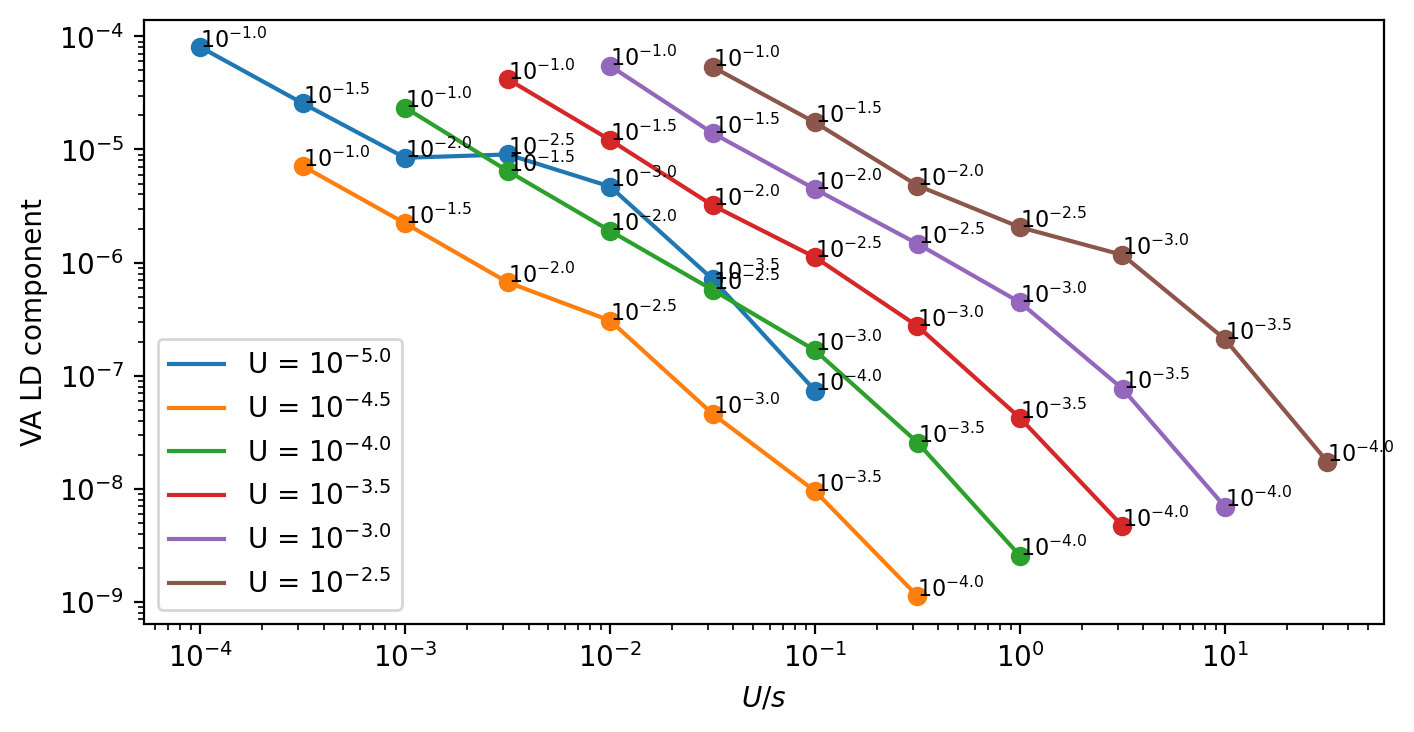

In [66]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    #T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vdiff = Vemp_ssh - Vemp
    Vemp = 4 * dgs['f_sd'].values**2 
    Vemp_ssh = 4 * dgs['sh'].values**2 * dgs['ssh'].values
    x = L * dgs['mu'].values/dgs['sh'].values
    lines = plt.plot(x, Vdiff, label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
    plt.scatter(x, Vdiff, c=lines[0].get_color())
    y = Vdiff
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (x[i], y[i]), fontsize=8)
        
plt.legend()
plt.ylabel('VA LD component')    
plt.xlabel('$U/s$')
plt.loglog()

Text(0.5, 0, 'genic - Va')

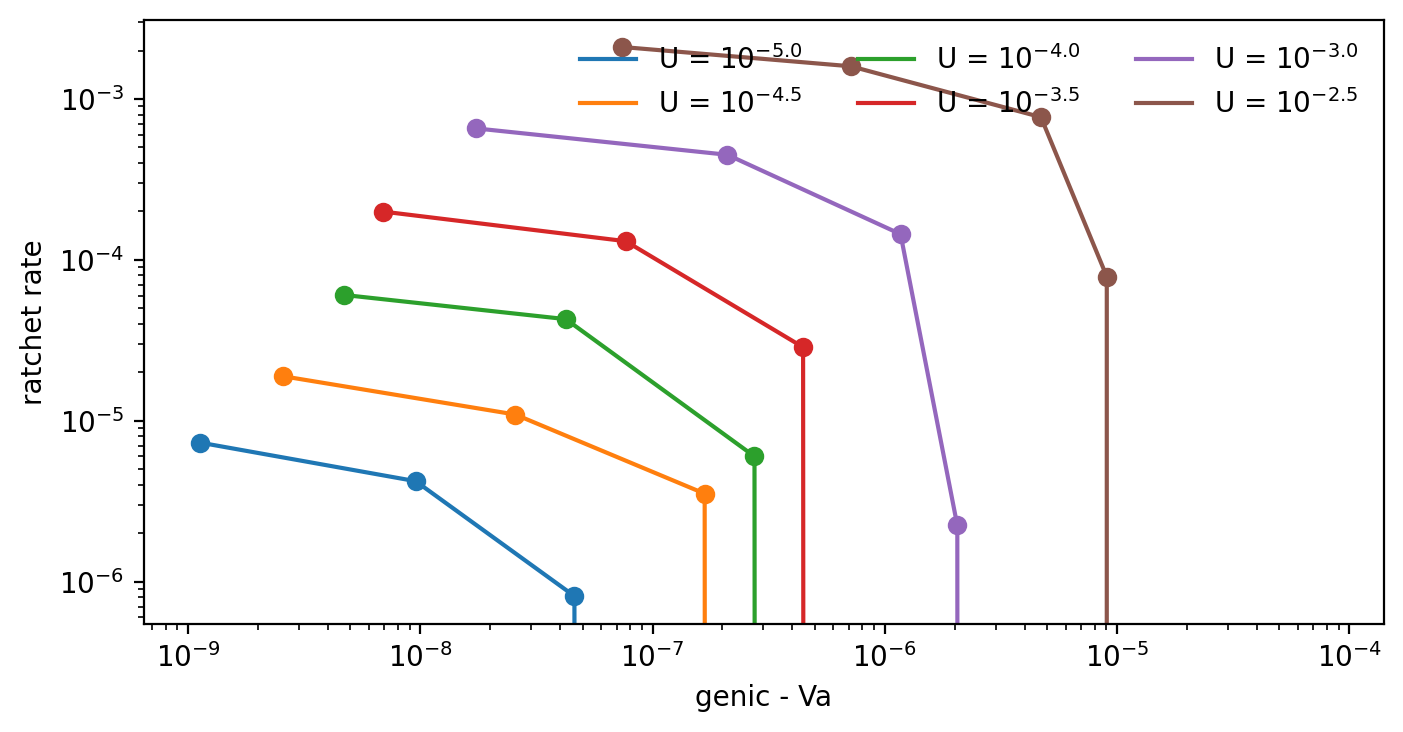

In [33]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    #T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vemp = 4 * dgs['f_sd'].values**2 
    Vemp_ssh = 4 * dgs['sh'].values**2 * dgs['ssh'].values
    vald = Vemp_ssh - Vemp
    #y = Vemp - Vemp_ssh 
    lines = plt.plot(vald, dgs['R'], label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
    plt.scatter(vald, dgs['R'], c=lines[0].get_color())

#plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.legend(ncol=3, frameon=False)
plt.ylabel('ratchet rate')
plt.xlabel('genic - Va')

Text(0.5, 0, 'R')

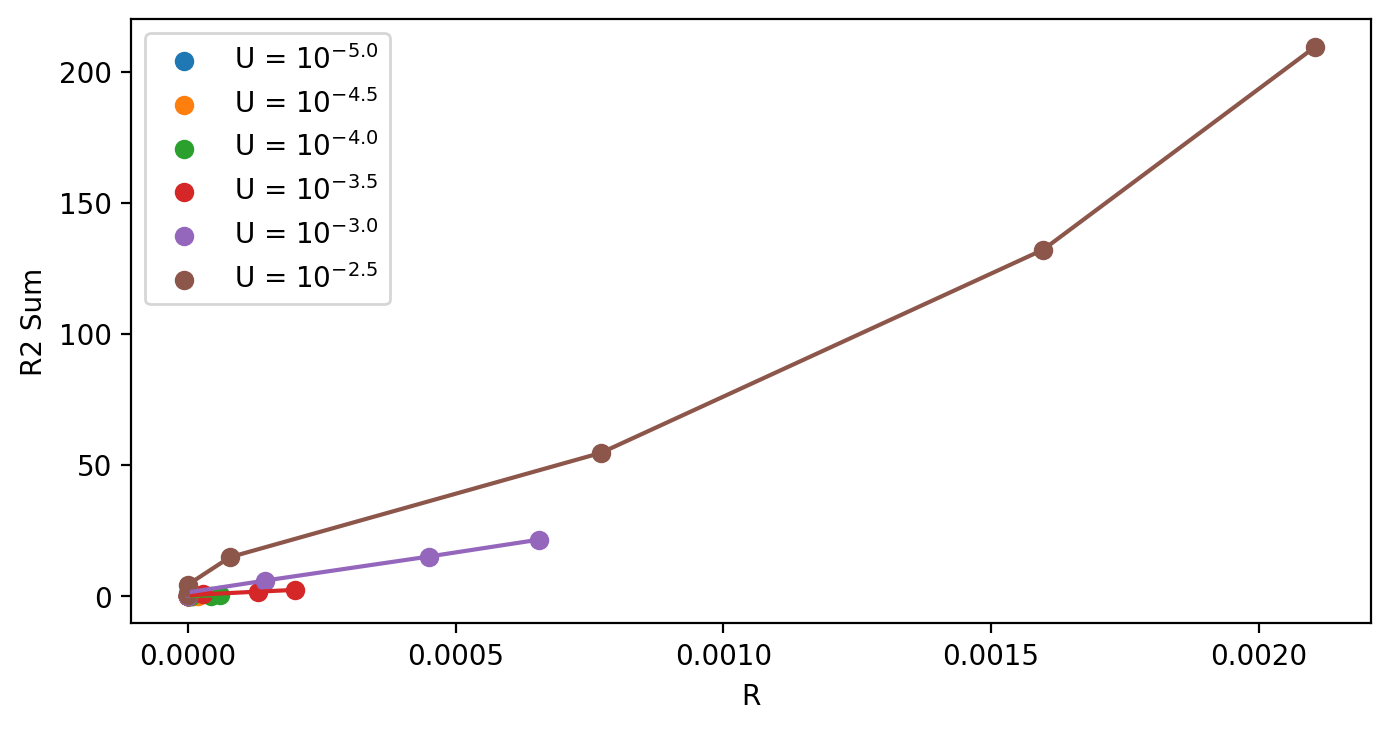

In [89]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]
    plt.plot(dgs['R'], dgs['r2sum'])
    plt.scatter(dgs['R'], dgs['r2sum'], label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
plt.legend()
#plt.semilogx()
plt.ylabel('R2 Sum')
plt.xlabel('R')

Text(0.5, 0, 'ratchet rate')

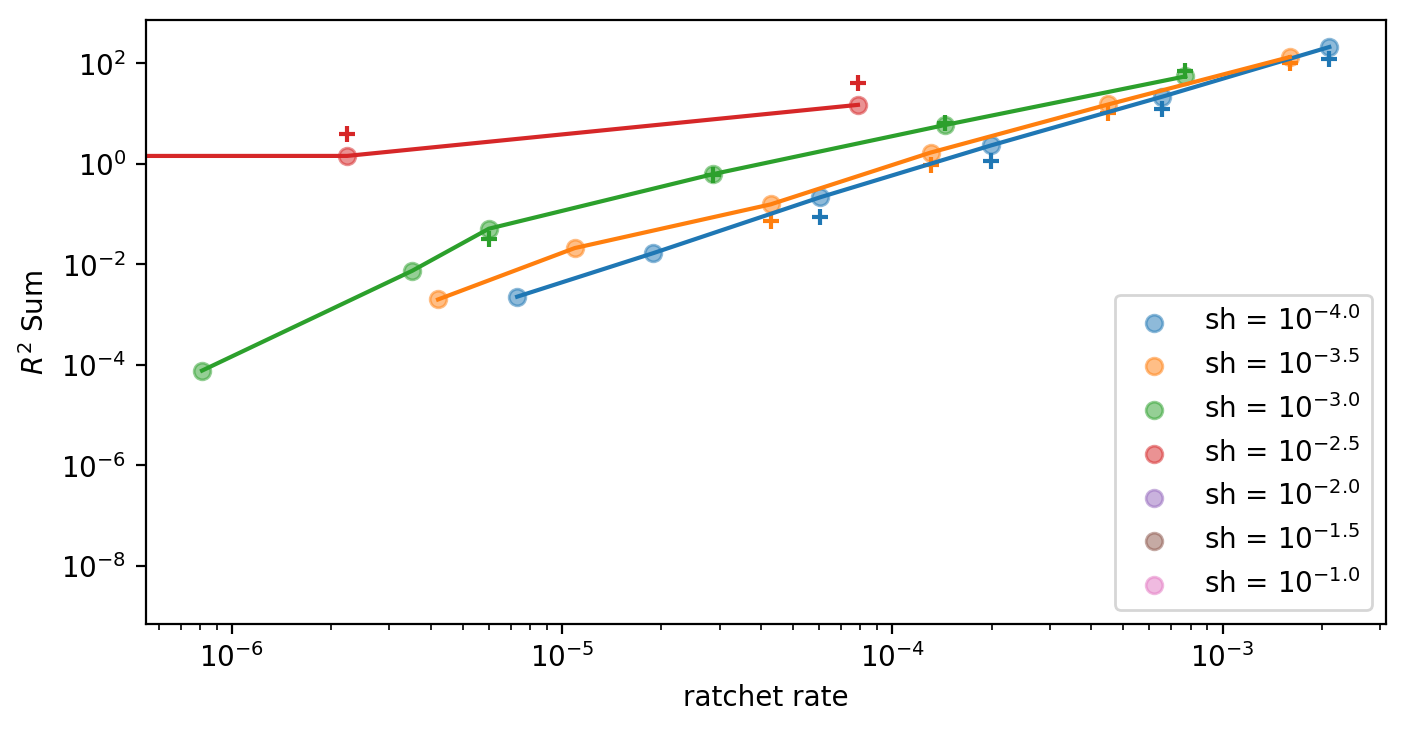

In [91]:
L = 1000000

for s in dg['sh'].unique():
    dgs = dg.loc[dg['sh'] == s]
    lines = plt.plot(dgs['R'], dgs['r2sum'])
    plt.scatter(dgs['R'], dgs['r2sum'], label=f"sh = $10^{{{np.round(np.log10(s), 2)}}}$", alpha=0.5)
    n = dgs['ldn']
    # NOTE: factor of two!
    plt.scatter(dgs['R'], neutral_ld(L, 1e-8, 1000) * 2 * n * (n-1), c=lines[0].get_color(), marker='+')
plt.legend()
plt.loglog()
plt.ylabel('$R^2$ Sum')
plt.xlabel('ratchet rate')

[]

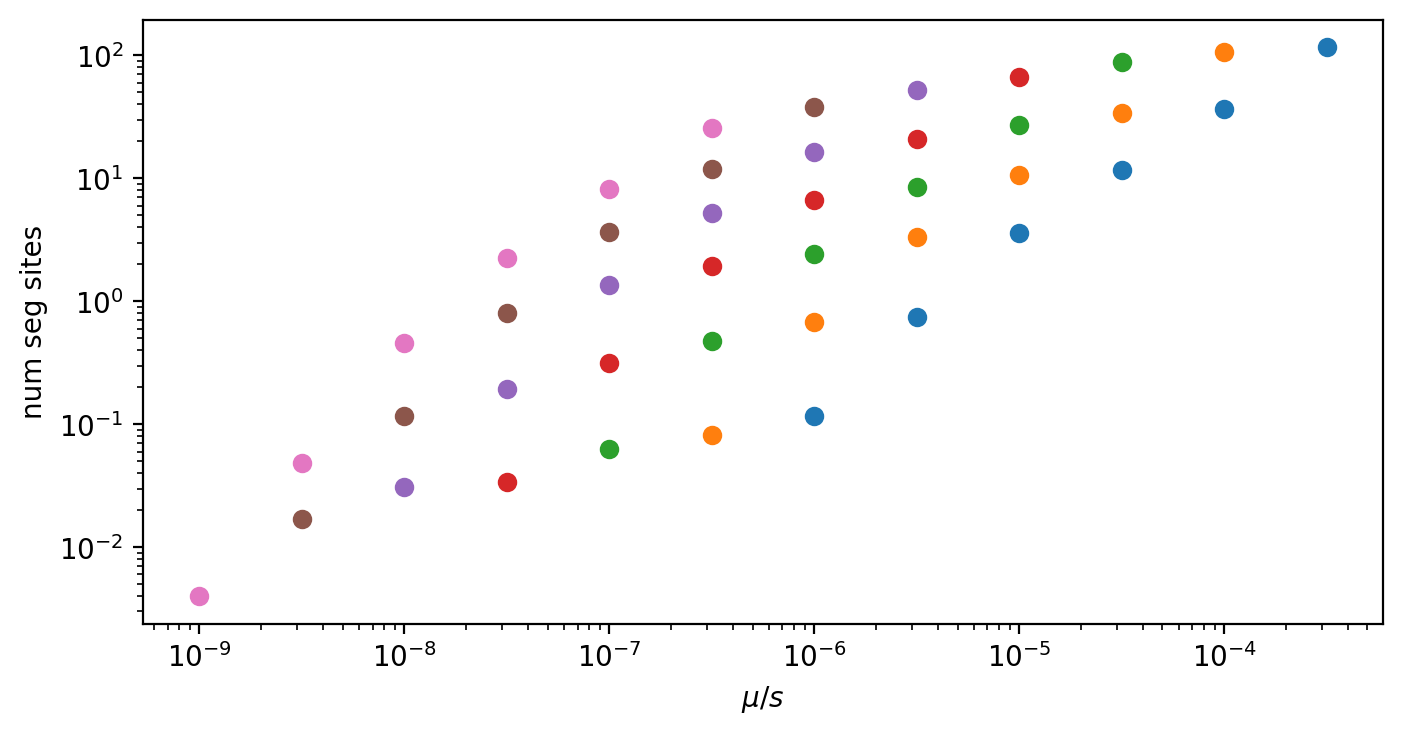

In [92]:
for s in dg['sh'].unique():
    dgs = dg.loc[dg['sh'] == s]
    plt.scatter(dgs['mu']/dgs['sh'], dgs['ldn'])
    #plt.plot(dgs['mu']/dgs['sh'], dgs['mu']/dgs['sh'])
plt.xlabel('$\mu/s$')
plt.ylabel('num seg sites')
plt.loglog()

[]

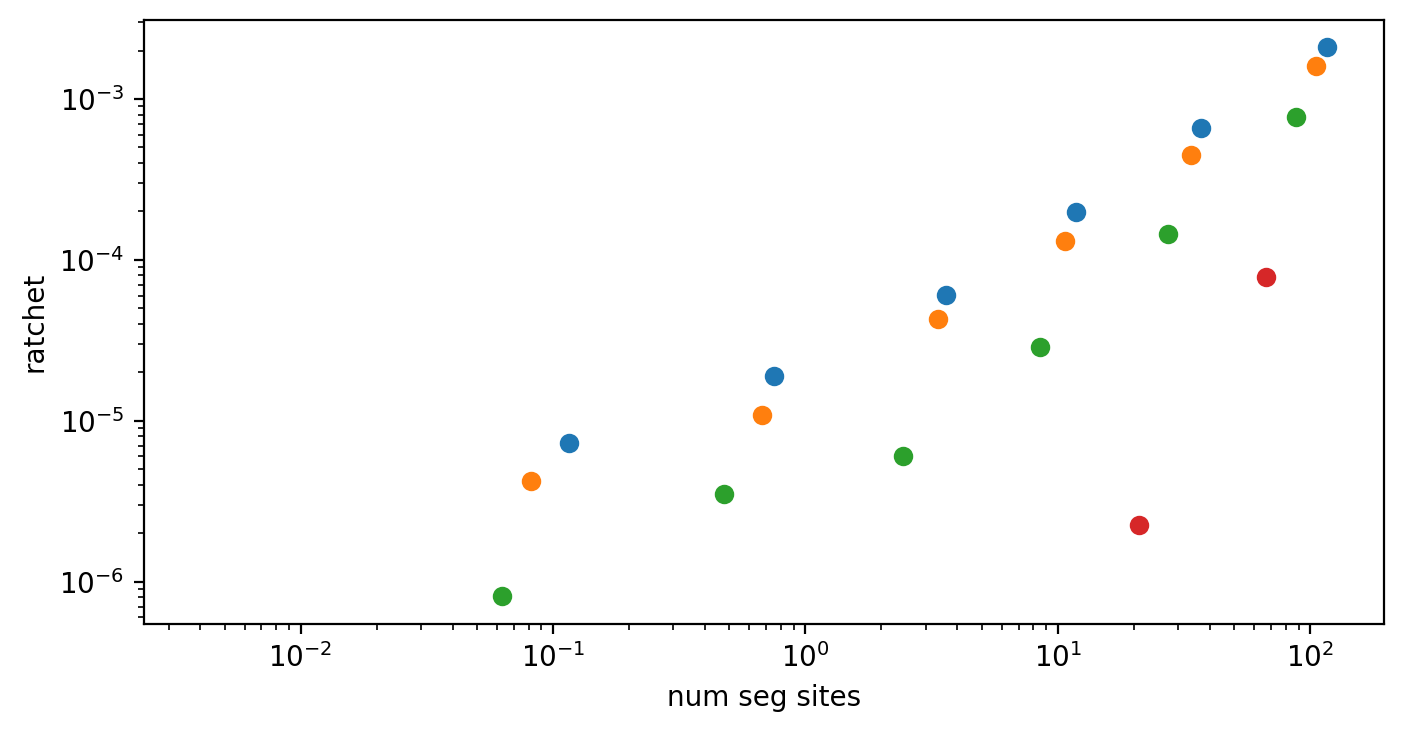

In [93]:
for s in dg['sh'].unique():
    dgs = dg.loc[dg['sh'] == s]
    plt.scatter(dgs['ldn'], dgs['R'])
    #plt.plot(dgs['mu']/dgs['sh'], dgs['mu']/dgs['sh'])
plt.xlabel('num seg sites')
plt.ylabel('ratchet')
plt.loglog()

Text(0.5, 0, 'R')

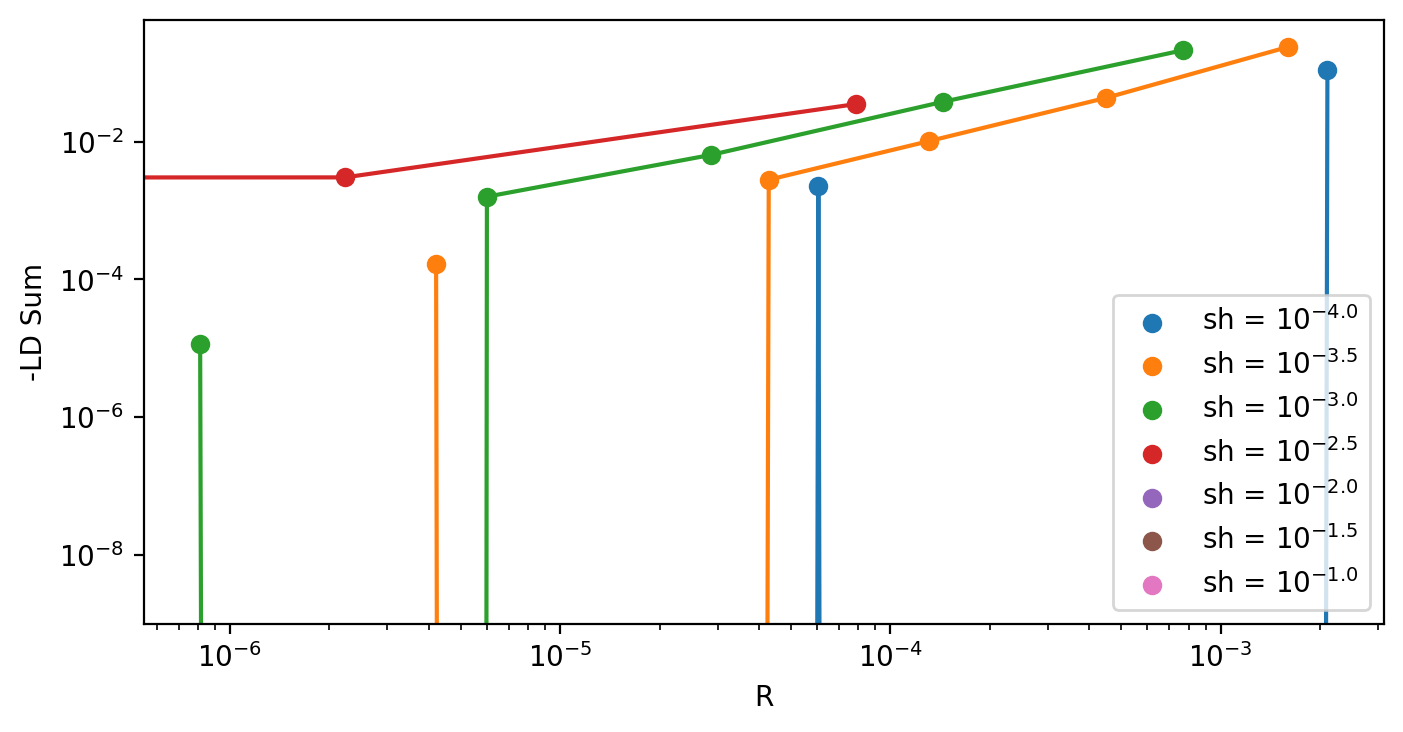

In [94]:

for s in dg['sh'].unique():
    dgs = dg.loc[dg['sh'] == s]
    lines = plt.plot(dgs['R'], -dgs['ldsum'])
    plt.scatter(dgs['R'], -dgs['ldsum'], label=f"sh = $10^{{{np.round(np.log10(s), 2)}}}$")
    n = dgs['ldn']
    #plt.scatter(dgs['R'], neutral_ld(L, 1e-8, 1000) * 2 * n * (n-1), c=lines[0].get_color(), alpha=0.1)
plt.legend()
plt.loglog()
plt.ylabel('-LD Sum')
plt.xlabel('R')

Text(0.5, 0, 'ratchet rate')

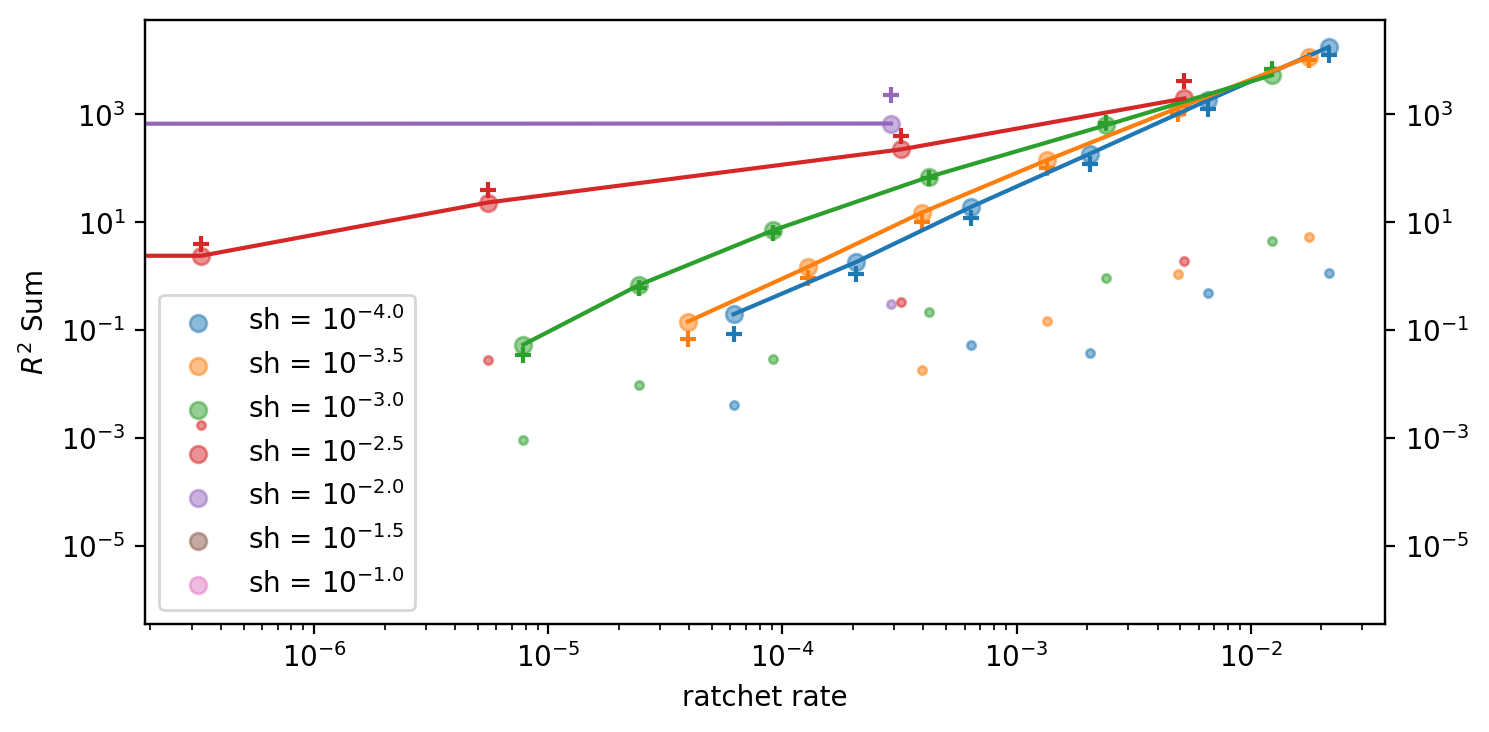

In [105]:
L = 1000000

f, ax = plt.subplots()
ax2 = ax.twinx()

for s in dg['sh'].unique():
    dgs = dg.loc[dg['sh'] == s]
    lines = plt.plot(dgs['R'], dgs['r2sum'])
    ax.scatter(dgs['R'], dgs['r2sum'], label=f"sh = $10^{{{np.round(np.log10(s), 2)}}}$", alpha=0.5)
    n = dgs['ldn']
    # NOTE: factor of two!
    ax.scatter(dgs['R'], neutral_ld(L, 1e-8, 1000) * 2 * n * (n-1), c=lines[0].get_color(), marker='+')
    
    ax2.scatter(dgs['R'], -dgs['ldsum'], label=f"sh = $10^{{{np.round(np.log10(s), 2)}}}$", marker='.', alpha=0.5)
ax.legend()
ax.loglog()
ax2.loglog()

ax.set_ylabel('$R^2$ Sum')
ax.set_xlabel('ratchet rate')